In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

# 先做一些准备工作

## 取数据

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
x_train,y_train,x_valid,y_valid = get_data()

In [7]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m,nh,10)

In [10]:
pred = model(x_train)

## cross entropy (negative log likelihood)

In [11]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

这里用的是对数softmax,原因见后面

In [12]:
sm_pred = log_softmax(pred)

In [13]:
y_train[:3]

tensor([5, 0, 4])

In [14]:
def nll(input, target): 
    return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.3079, grad_fn=<NegBackward>)

注意这个恒等式

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

计算对数softmax时候给出了一个简单的方法 `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [17]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred),y_train),loss)

这里有一个小技巧[LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). 如下公式所述

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

ａ是最大的$x_j$,这让我们降低了浮点数误差

In [19]:
def logsumexp(x):
    a = x.max(-1)[0]
    return a + (x-a[:,None]).exp().sum(-1).log()

## pytorch中已经有logsumexp的实现了

In [20]:
test_near(logsumexp(pred),pred.logsumexp(-1))

In [21]:
def log_softmax(x):
    return x - x.logsumexp(-1,keepdim=True)

In [22]:
test_near(nll(log_softmax(pred),y_train),loss)

## 之后我们就用pytorch的

In [23]:
test_near(F.nll_loss(F.log_softmax(pred,-1),y_train),loss)

## pytorch里面，nll_loss和softmax合并了变成了cross_entropy

In [24]:
test_near(F.cross_entropy(pred,y_train),loss)

# 我们可以开始训练了

## 基础版本训练

In [25]:
loss_func = F.cross_entropy

In [26]:
#export
def accuracy(out,yb):
    return (torch.argmax(out,1)==yb).float().mean()

In [27]:
bs = 64

xb = x_train[:bs]
preds = model(xb)
preds[0],preds.shape

(tensor([-0.0093,  0.0343,  0.0628,  0.0868, -0.1075,  0.0096, -0.1835, -0.0647,
         -0.0648,  0.0343], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [28]:
yb = y_train[:bs]
loss_func(preds,yb)

tensor(2.2886, grad_fn=<NllLossBackward>)

In [29]:
accuracy(preds,yb)

tensor(0.1875)

In [30]:
lr = 0.5
epochs = 1

In [31]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb),yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [32]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.2588, grad_fn=<NllLossBackward>), tensor(0.9375))

## parameters重构一下训练的代码

In [33]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb),yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [34]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.2588, grad_fn=<NllLossBackward>), tensor(0.9375))

In [35]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [36]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

## 然后我们就可以用 nn.Module.__setattr__来提高效率
这也就是为什么我们要写super().__init__()，就是为了初始化_modules,以及后面的__setattr__()

In [37]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
    
    def __call__(self,x):
        return self.l2(F.relu(self.l1(x)))

In [38]:
model = Model(m,nh,10)

In [39]:
for name,l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [40]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

## 我们用list的方式来重构一下层

In [41]:
layers = [nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10)]

In [42]:
class Model(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}',l)
    
    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x

In [43]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## 我们想到的这个在ModuleList中已经有了

In [44]:
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x

In [45]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

## 进一步重构，我们就得到了最常见的 Sequential

In [46]:
model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## 接下来，我们利用optim简化训练

In [47]:
class Optimizer():
    def __init__(self,params,lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [48]:
model = nn.Sequential(
    nn.Linear(m,nh),
    nn.ReLU(),
    nn.Linear(nh,10)
)

In [49]:
opt = Optimizer(model.parameters())

In [50]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb),yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [51]:
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
loss,acc

(tensor(0.0473, grad_fn=<NllLossBackward>), tensor(1.))

## 我们实现的就是optim.SGD()

In [52]:
#export
from torch import optim

In [53]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [54]:
model,opt = get_model()
loss_func(model(xb),yb)

tensor(2.3516, grad_fn=<NllLossBackward>)

In [55]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0294, grad_fn=<NllLossBackward>), tensor(1.))

In [56]:
assert acc>.7

# 再来简化构造数据集的步骤

## DataSet()绑定x,y

In [57]:
#export
class Dataset():
    def __init__(self,x,y):
        self.x,self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]

In [58]:
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [59]:
xb,yb = train_ds[:5]
assert xb.shape==(5,784)
assert yb.shape==(5,)

In [60]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0110, grad_fn=<NllLossBackward>), tensor(1.))

## 构造DataLoader
每次去取一个batch size的mini batch

In [61]:
class DataLoader():
    def __init__(self,ds,bs):
        self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0,len(self.ds),self.bs):
            yield self.ds[i:i+self.bs]

In [62]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs)

In [63]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,784)
assert yb.shape==(bs,)

tensor(3)

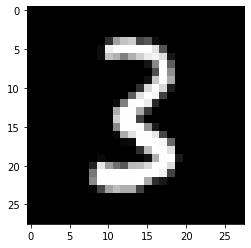

In [64]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [65]:
model,opt = get_model()

In [66]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [67]:
fit()

In [68]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1367, grad_fn=<NllLossBackward>), tensor(0.9688))

## 随机取样

In [69]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [70]:
small_ds = Dataset(*train_ds[:10])

In [72]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [73]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([4, 3, 8]), tensor([6, 9, 7]), tensor([5, 0, 2]), tensor([1])]

In [74]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self,ds,sampler,collate_fn = collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
    
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [75]:
train_samp = Sampler(train_ds,bs,shuffle=True)
valid_samp = Sampler(valid_ds,bs,shuffle=False)

In [76]:
train_dl = DataLoader(train_ds,sampler=train_samp,collate_fn=collate)
valid_dl = DataLoader(valid_ds,sampler=valid_samp,collate_fn=collate)

tensor(3)

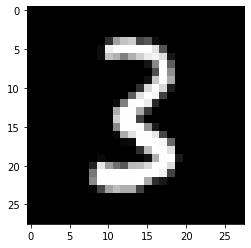

In [78]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(4)

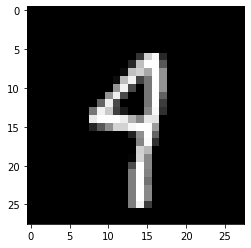

In [80]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

## Pytorch DataLoader
pytorch里面用的是SequentialSampler和RandomSampler

In [81]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [82]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [83]:
model,opt = get_model()
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.2553, grad_fn=<NllLossBackward>), tensor(0.9219))

一般情况下，你不需要用SequentialSampler和RandomSampler

In [84]:
train_dl = DataLoader(train_ds,bs,shuffle=True,drop_last=True)
valid_dl = DataLoader(valid_ds,bs,shuffle=False)

In [85]:
model,opt = get_model()
fit()
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
assert acc>0.7
loss,acc

(tensor(0.1960, grad_fn=<NllLossBackward>), tensor(0.9062))

**pytorch中你的dataloader支持多线程**

# Validation
1. 我们可以通过model.train(),model.eval()看现在的模式，因为有一些层在train和evaluation上面的行为不太一样
2. 然后在eval阶段，不需要backward pass和计算梯度
3. eval阶段记录一下累计的loss和accuracy

In [86]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [88]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

**但是实际上，batch_size可能不太一样，所以实际上累和acc和loss的时候我们应该使用加权的方式**

In [89]:
train_dl,valid_dl = get_dls(train_ds,valid_ds,bs)
model,opt = get_model()
loss,acc = fit(5,model,loss_func,opt,train_dl,valid_dl)

0 tensor(0.1873) tensor(0.9457)
1 tensor(0.1309) tensor(0.9628)
2 tensor(0.1260) tensor(0.9626)
3 tensor(0.1142) tensor(0.9660)
4 tensor(0.1292) tensor(0.9625)


In [90]:
assert acc > .9

# 导出

In [91]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
